In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

C:\Users\new user\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.sparse import csr_matrix, issparse


In [2]:

# --- 1. Load Feature Names ---
# This step is needed to get the 'features' variable you used.
# We read the 2nd column (index 1) from features.txt.
try:
    features_df = pd.read_csv('UCI HAR Dataset/features.txt', delim_whitespace=True, header=None)
    feature_names = features_df[1].tolist()
except FileNotFoundError:
    print("Error: 'features.txt' not found. Make sure it's in the 'UCI HAR Dataset' folder.")
    # You would typically exit or handle this error, but for demonstration:
    feature_names = [] # Set to empty list to show the error

# --- 2. Load Training Data (X_train) ---
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)

# Set the column names
if feature_names:
    X_train.columns = feature_names # <-- Fixed: No extra brackets [ ]
else:
    print("Warning: Feature names not loaded. Columns will be numbered.")

# --- 3. Load Subject Data ---
# FIX: Read the CSV, then select the first column (index 0) to get a Series.
subject_series = pd.read_csv('UCI HAR Dataset/train/subject_train.txt', header=None)[0]

# --- 4. Load Activity Labels (y_train) ---
# FIX: Read with a proper column name, then select that column to get a Series.
y_train_series = pd.read_csv('UCI HAR Dataset/train/y_train.txt', header=None, names=['Activity'])['Activity']

# --- 5. Combine All Data into One DataFrame ---
# It's good practice to copy X_train to avoid modifying the original
train = X_train.copy()

# Add the new columns
train['subject'] = subject_series
train['Activity'] = y_train_series

# --- 6. Map Activity Names ---
# Your mapping code is perfect!
activity_map = {
    1: 'WALKING', 
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING', 
    5: 'STANDING',
    6: 'LAYING'
}

train['ActivityName'] = train['Activity'].map(activity_map)

# --- 7. Display a Sample ---
# Using .head() or .sample() is a great way to check your work
print("Data loaded successfully. Displaying first few data set:")
train.head(2)



C:\Users\new user\AppData\Local\Temp\ipykernel_6588\1967201394.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features_df = pd.read_csv('UCI HAR Dataset/features.txt', delim_whitespace=True, header=None)
C:\Users\new user\AppData\Local\Temp\ipykernel_6588\1967201394.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)


Data loaded successfully. Displaying first few data set:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING


In [3]:
# --- 1. Load Test Data (X_test) ---
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)

# Set the column names
if 'feature_names' in locals():
    X_test.columns = feature_names # <-- Fixed: No extra brackets [ ]
else:
    print("Warning: 'feature_names' not found. Columns will be numbered.")

# --- 2. Load Subject Data ---
# FIX: Read the CSV, then select the first column (index 0) to get a Series.
subject_series_test = pd.read_csv('UCI HAR Dataset/test/subject_test.txt', header=None)[0]

# --- 3. Load Activity Labels (y_test) ---
# FIX: Read with a proper column name, then select that column to get a Series.
y_test_series = pd.read_csv('UCI HAR Dataset/test/y_test.txt', header=None, names=['Activity'])['Activity']

# --- 4. Combine All Data into One DataFrame ---
# Use .copy() to prevent SettingWithCopyWarning
test = X_test.copy()

# Add the new columns
test['subject'] = subject_series_test
test['Activity'] = y_test_series

# --- 5. Map Activity Names ---
# Your mapping code is perfect!
activity_map = {
    1: 'WALKING', 
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING', 
    5: 'STANDING',
    6: 'LAYING'
}

test['ActivityName'] = test['Activity'].map(activity_map)

# --- 6. Display a Sample ---
print("Test data loaded successfully. Displaying a random sample:")
print(test.head(2))


C:\Users\new user\AppData\Local\Temp\ipykernel_6588\2637941692.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)


Test data loaded successfully. Displaying a random sample:
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.257178          -0.023285          -0.014654         -0.938404   
1           0.286027          -0.013163          -0.119083         -0.975415   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.920091         -0.667683         -0.952501         -0.925249   
1         -0.967458         -0.944958         -0.986799         -0.968401   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  angle(tBodyAccMean,gravity)  \
0         -0.674302         -0.894088  ...                     0.006462   
1         -0.945823         -0.894088  ...                    -0.083495   

   angle(tBodyAccJerkMean),gravityMean)  angle(tBodyGyroMean,gravityMean)  \
0                               0.16292                         -0.825886   
1                               0.01750                         -0.434375   

   angle(t

In [5]:
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train.ActivityName

X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test.ActivityName

print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((7352, 561),(7352,))
X_test  and y_test  : ((2947, 561),(2947,))


In [7]:
#Labels that are useful in plotting confusion matrix
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
#Let's make a function to plot the confusion matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
from datetime import datetime
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done....!\n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done....!\n')
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
   
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(6,6))
    
    # --- THIS IS THE FIX ---
    plt.grid(False) # Changed from plt.grid(b=False)
    # -----------------------
    
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('****************| Classifiction Report |****************')
    classification_report = metrics.classification_report(y_test, y_pred)
   
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results

In [9]:
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))


    # parameters that gave best results while performing grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))


    #  number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal numbre of cross validation sets: {}'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search 
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of best estimator : {}'.format(model.best_score_))

    

training the model..


C:\Users\new user\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2896: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Done....!

==> training time:- 0:03:13.058018

Predicting test data
Done....!

==> testing time:- 0:00:00.055061

==> Accuracy:- 0.9267051238547676


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 437  54   0   0   0]
 [  0  44 488   0   0   0]
 [  0   0   0 482   7   7]
 [  0   0   0  23 352  45]
 [  0   0   0  30   6 435]]


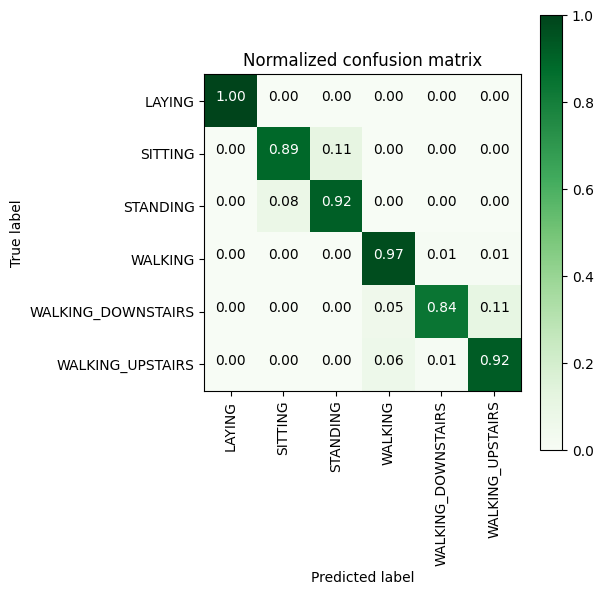

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.91      0.89      0.90       491
          STANDING       0.90      0.92      0.91       532
           WALKING       0.90      0.97      0.94       496
WALKING_DOWNSTAIRS       0.96      0.84      0.90       420
  WALKING_UPSTAIRS       0.89      0.92      0.91       471

          accuracy                           0.93      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.93      0.93      2947



==> Best Estimator:
	RandomForestClassifier(max_depth=np.int64(13), n_estimators=np.int64(190))


==> Best parameters:
	Parameters of best estimator : {'max_depth': np.int64(13), 'n_estimators': np.int64(190)}

==> No. of CrossValidation sets:
	Total numbre of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of b

In [10]:
params = {'n_estimators': np.arange(10,201,20), 'max_depth':np.arange(3,15,2)}
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, param_grid=params, n_jobs=-1)
rfc_grid_results = perform_model(rfc_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# observe the attributes of the model 
print_grid_search_attributes(rfc_grid_results['model'])

Running feature selection experiment...
Features:   1, Accuracy:  39.70%, Train Time: 0.232s
Features:   2, Accuracy:  56.57%, Train Time: 0.222s
Features:   3, Accuracy:  59.86%, Train Time: 0.210s
Features:   4, Accuracy:  64.78%, Train Time: 0.231s
Features:   5, Accuracy:  64.23%, Train Time: 0.239s
Features:   6, Accuracy:  62.44%, Train Time: 0.246s
Features:   7, Accuracy:  60.74%, Train Time: 0.238s
Features:   8, Accuracy:  60.10%, Train Time: 0.243s
Features:   9, Accuracy:  61.59%, Train Time: 0.268s
Features:  10, Accuracy:  61.28%, Train Time: 0.278s
Features:  11, Accuracy:  62.47%, Train Time: 0.279s
Features:  12, Accuracy:  62.16%, Train Time: 0.257s
Features:  13, Accuracy:  70.95%, Train Time: 0.254s
Features:  14, Accuracy:  72.82%, Train Time: 0.250s
Features:  15, Accuracy:  74.52%, Train Time: 0.289s
Features:  16, Accuracy:  74.35%, Train Time: 0.296s
Features:  17, Accuracy:  74.62%, Train Time: 0.273s
Features:  18, Accuracy:  77.60%, Train Time: 0.272s
Featur

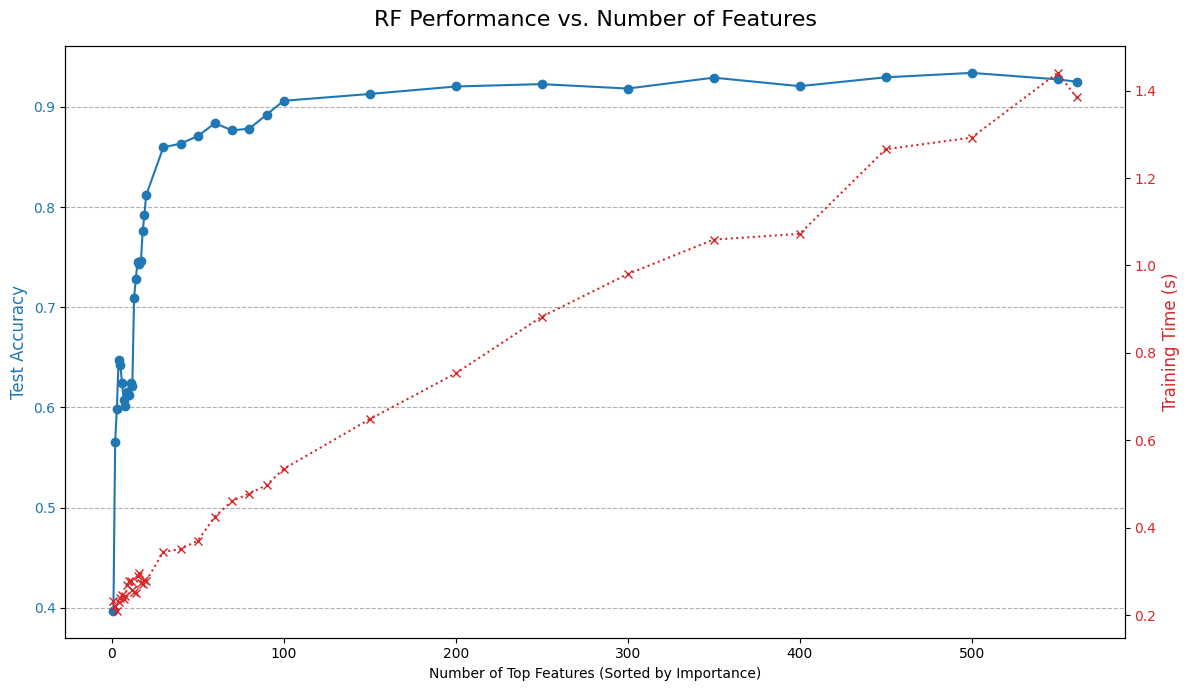


Max accuracy achieved: 93.38%
Accuracy within 98% of max (91.52%) was first achieved with 200 features.


In [11]:

from sklearn.metrics import accuracy_score
import time

# --- 1. Get Best Model and Sorted Features ---

# Get the best-performing model from the grid search
try:
    best_rf_model = rfc_grid_results['model'].best_estimator_
except NameError:
    print("Error: 'rf_grid_results' not found. Please run your RF grid search first.")
    # As a fallback, create a default model (replace this if needed)
    # best_rf_model = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)

# Get the feature importances
importances = best_rf_model.feature_importances_

# Get the names of the features from X_train's columns
feature_names = X_train.columns

# Create a DataFrame, sort by importance, and get the sorted list of names
importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

sorted_features = importances_df['feature'].tolist()

# --- 2. Test Accuracy at Different Feature Counts ---

# Define the steps (number of features) to test
# We'll test 1, 5, 10, 20, 30... up to all 561
feature_counts = list(range(1, 21)) + list(range(30, 101, 10)) + list(range(150, 562, 50))
if 561 not in feature_counts:
    feature_counts.append(561) # Ensure we test the full set

accuracies = []
training_times = []

print("Running feature selection experiment...")

for n_features in feature_counts:
    
    # Select the top N features
    top_n_feature_list = sorted_features[:n_features]
    
    # Create new train/test sets with just these features
    X_train_top_n = X_train[top_n_feature_list]
    X_test_top_n = X_test[top_n_feature_list]
    
    # Re-train a *new* RF model (using good defaults, no grid search needed)
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    
    start_time = time.time()
    model.fit(X_train_top_n, y_train)
    end_time = time.time()
    
    # Predict and calculate accuracy
    y_pred = model.predict(X_test_top_n)
    acc = accuracy_score(y_test, y_pred)
    
    accuracies.append(acc)
    training_times.append(end_time - start_time)
    
    print(f"Features: {n_features:3}, Accuracy: {acc*100:6.2f}%, Train Time: {end_time - start_time:.3f}s")

# --- 3. Plot the Results ---

# Create a DataFrame for plotting
results_df = pd.DataFrame({
    'Number of Features': feature_counts,
    'Accuracy': accuracies,
    'Training Time (s)': training_times
})

# Create a plot with two y-axes (Accuracy and Time)
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Accuracy on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Number of Top Features (Sorted by Importance)')
ax1.set_ylabel('Test Accuracy', color=color, fontsize=12)
ax1.plot(results_df['Number of Features'], results_df['Accuracy'], color=color, marker='o', label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, axis='y', linestyle='--')

# Create a second y-axis for Training Time
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Training Time (s)', color=color, fontsize=12)  
ax2.plot(results_df['Number of Features'], results_df['Training Time (s)'], color=color, marker='x', linestyle=':', label='Training Time')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('RF Performance vs. Number of Features', fontsize=16)
fig.tight_layout()  
plt.show()

# Find the point of diminishing returns (e.g., 98% of max accuracy)
max_accuracy = max(accuracies)
target_accuracy = max_accuracy * 0.98

optimal_n_features = feature_counts[np.where(np.array(accuracies) >= target_accuracy)[0][0]]
print(f"\nMax accuracy achieved: {max_accuracy*100:.2f}%")
print(f"Accuracy within 98% of max ({target_accuracy*100:.2f}%) was first achieved with {optimal_n_features} features.")